In [1]:
import numpy as np
import pandas as pd

# Data preparation

In [2]:
# load data
df_rain = pd.read_csv('Growth/voiholm_rain.csv')
df_ride = pd.read_csv('Growth/voiholm_ride.csv')
df_temp = pd.read_csv('Growth/voiholm_temperature.csv')

### Fill NaN (number_of_ready_vehicles) with average vehicle usage rate

In [3]:
df_ride['vehicle_usage'] = df_ride.number_of_vehicles_used/df_ride.number_of_ready_vehicles
usage_mean = df_ride['vehicle_usage'].mean()
df_ride['number_of_ready_vehicles'].fillna(df_ride.number_of_vehicles_used/usage_mean, inplace = True)
df_ride['vehicle_usage'].fillna(usage_mean, inplace = True)
df_ride.head()

,date,number_of_rides,number_of_riders,number_of_vehicles_used,median_ride_distance_meters,median_avg_speed,median_ride_duration,number_of_ready_vehicles,vehicle_usage
0,2019-04-27,8391,5831,1122,864.174380,5.489825,9.733333,1842.088866,0.609091
1,2020-09-01,13176,7574,2962,1274.404017,12.296830,6.616667,3621.000000,0.818006
2,2019-02-15,6072,4462,1703,791.800661,7.459770,7.316667,2795.969107,0.609091
3,2019-09-25,12199,8598,3035,1301.116774,13.349908,6.016667,6651.000000,0.456322
4,2019-07-04,12267,8614,2711,876.581699,8.997238,6.616667,6336.000000,0.427872


### Group temperature by date, and calculate [min, max, mean, var] of daily temperature
##### Another way can be keeping the temp from three time, they may have different weights in the model

In [4]:
df_temp = df_temp.groupby('date').outdoor_temperature.agg(['min', 'max', 'mean', 'var']).rename(columns={'min': 'temp_min', 'max': 'temp_max', 'mean': 'temp_max', 'var': 'temp_var'}).reset_index()
df_temp.head()

,date,temp_min,temp_max,temp_max,temp_var
0,1859-01-01,-1.8,1.8,0.300000,3.510000
1,1859-01-02,-1.5,2.0,0.766667,3.863333
2,1859-01-03,-4.0,4.0,-0.233333,16.163333
3,1859-01-04,-2.9,1.5,-0.300000,5.320000
4,1859-01-05,-1.0,0.5,-0.466667,0.703333


### Join all dataframes together

In [5]:
df = df_ride.merge(df_temp, on = 'date', how = 'left').merge(df_rain, on = 'date', how = 'left')

In [6]:
df.head()

,date,number_of_rides,number_of_riders,number_of_vehicles_used,median_ride_distance_meters,median_avg_speed,median_ride_duration,number_of_ready_vehicles,vehicle_usage,temp_min,temp_max,temp_max,temp_var,precipitation
0,2019-04-27,8391,5831,1122,864.174380,5.489825,9.733333,1842.088866,0.609091,12.6,16.7,14.800000,4.270000,0.0
1,2020-09-01,13176,7574,2962,1274.404017,12.296830,6.616667,3621.000000,0.818006,12.5,16.1,14.300000,6.480000,0.0
2,2019-02-15,6072,4462,1703,791.800661,7.459770,7.316667,2795.969107,0.609091,3.9,8.0,5.633333,4.503333,0.0
3,2019-09-25,12199,8598,3035,1301.116774,13.349908,6.016667,6651.000000,0.456322,9.2,14.5,11.466667,7.463333,0.0
4,2019-07-04,12267,8614,2711,876.581699,8.997238,6.616667,6336.000000,0.427872,11.7,17.4,14.500000,8.130000,8.0


### Feature engineer on "date"

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df['day-of-week'] = df['date'].dt.day_name()
df.sort_values(by='date').head()

,date,number_of_rides,number_of_riders,number_of_vehicles_used,median_ride_distance_meters,median_avg_speed,median_ride_duration,number_of_ready_vehicles,vehicle_usage,temp_min,temp_max,temp_max,temp_var,precipitation,day-of-week
785,2018-08-24,1,1,1,0.0,0.0,224.483333,1.641790,0.609091,18.9,25.1,21.133333,11.863333,0.6,Friday
307,2018-08-25,180,134,140,0.0,0.0,66.858334,229.850661,0.609091,13.4,18.5,16.033333,6.523333,2.3,Saturday
623,2018-08-26,40,29,24,0.0,0.0,10.700000,39.402970,0.609091,11.7,18.0,13.966667,12.263333,3.5,Sunday
61,2018-08-27,28,20,13,0.0,0.0,8.733333,21.343276,0.609091,11.9,18.1,14.133333,11.863333,4.1,Monday
634,2018-08-28,50,37,13,0.0,0.0,6.491667,21.343276,0.609091,15.2,20.8,17.866667,7.893333,0.0,Tuesday


# Model

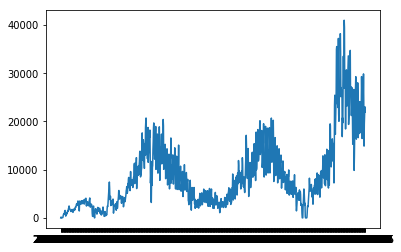

In [66]:
import matplotlib.pyplot as plt
plt.plot('date', 'number_of_rides', data = df.sort_values(by='date'))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [50]:
y = df['number_of_rides']
X = df.drop(['date', 'number_of_rides'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def model_fit(x, y, grid, random_state=42):
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import TimeSeriesSplit
    validation = TimeSeriesSplit(5)
    estimator = Ridge(grid)
    estimator = GridSearchCV(estimator=estimator,
                             scoring='neg_mean_squared_error',
                             param_grid=grid,
                             cv=validation,
                             n_jobs=-1,
                             verbose=1)
    estimator.fit(x.values, y.values.ravel())
    logging.info('Best hyper-parameter: %s', estimator.best_estimator_)
    estimator = estimator.best_estimator_
    return estimator.fit(x.values, y.values.ravel())